## Deep Q Network (using a Neural Network)
This code is based on the *Lecture 6* from the excelent [course on Reinforcement Learning](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html) by David Silver.

It implements a Neural Network to learn the game Cart-pole. 
TD learning with fixed Q-target and Experience Replay.

In [1]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import gym

from IPython.display import clear_output
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
%matplotlib inline

Number of possible actions: 2
Number of possible states: Box(4,)


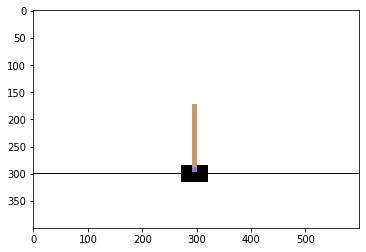

In [2]:
"""
CartPole environment.
https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. 
The pendulum starts upright, and the goal is to prevent it from falling over by increasing and 
reducing the cart's velocity.

Observation: 
    Type: Box(4)
    Num	Observation                 Min         Max
    0	Cart Position             -4.8            4.8
    1	Cart Velocity             -Inf            Inf
    2	Pole Angle                 -24 deg        24 deg
    3	Pole Velocity At Tip      -Inf            Inf

Actions:
    Type: Discrete(2)
    Num	Action
    0	Push cart to the left
    1	Push cart to the right
""" 

ENV_NAME = "CartPole-v0"

env = gym.make(ENV_NAME).env

print("Number of possible actions:", env.action_space.n)
print("Number of possible states:", env.observation_space)

env.reset()
plt.imshow(env.render("rgb_array"))

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
class DQNAgent:
    def __init__(self, n_action_space, n_observation_space, epsilon, discount_factor):
        self.n_action_space = n_action_space
        self.n_observation_space = n_observation_space
        
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        
        self.qnetwork = nn.Sequential(
                    nn.Linear(n_observation_space[0], 192),
                    nn.ReLU(),
                    nn.Linear(192, 128),
                    nn.ReLU(),
                    nn.Linear(128, n_action_space)
        ).to(device)
        
    def get_action_epsilon_greedy(self, qvalues):    
        # the action returned either will be random or the greedy
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_action_space) # return a random action
        else: # else, be greedy
            action = np.argmax(qvalues)
        return action
    
    def get_action_greedy_policy(self, qvalues):
            return np.argmax(qvalues)
    
    def get_qvalues(self, state):
        state = torch.tensor(state, dtype=torch.float, device=device)
        return self.qnetwork(state).cpu().detach().numpy()

In [5]:
def calculate_loss(state_batch, action_batch, new_state_batch, reward_batch, done_batch):
    # convert variables to tensor
    state_batch = torch.tensor(state_batch, dtype=torch.float, device=device)
    new_state_batch = torch.tensor(new_state_batch, dtype=torch.float, device=device)
    reward_batch = torch.tensor(reward_batch, dtype=torch.float, device=device)
    done_batch = torch.tensor(done_batch, dtype=torch.uint8, device=device)
    
    not_done_batch = 1 - done_batch

    # predict all q-values for current state
    all_qvalues_state = agent.qnetwork(state_batch)

    # select the q_value for the agent action
    qvalue_state = all_qvalues_state[range(len(all_qvalues_state)), action_batch]
    
    # predict all q-values for the new state 
    all_qvalues_new_state = target.qnetwork(new_state_batch)

    # select the q-value for the new state for the action that maximises it, q'(s',amax)
    qvalue_new_state = torch.tensor([torch.max(all_qvalues_new_state[i]).item() for i in range(len(all_qvalues_new_state))],
                                     dtype=torch.float32, device=device)
    
    # for TD target if it's a terminal state (done == 1) the target receives only the value of the reward
    # not_done_batch is a vector that when multiplied by the value function does that job.
    td_target = reward_batch + agent.discount_factor*qvalue_new_state*not_done_batch

    # loss = MSE (mean squared error) of TD error (Q-network - Q-learning targets)
    # the detach is a way to fix the target network by not having its gradients computed
    loss = F.mse_loss(qvalue_state, td_target.detach())

    return loss

In [6]:
def play_n_steps(agent, start_state, n_steps=1):
    
    state = start_state
    total_reward = 0.0
    
    for _ in range(n_steps):
        qvalues = agent.get_qvalues(state) # get qvalues for current state
        action = agent.get_action_epsilon_greedy(qvalues) # get action based on e-greedy policy
        
        new_state, reward, done, info = env.step(action)
        
        # record current step variables
        memory.push(state, action, new_state, reward, done)
        
        if done:
            state = env.reset()
        else:
            state = new_state
            
        total_reward += reward
        
    return state, total_reward

In [7]:
class ReplayMemory:
    def __init__(self, memory_size):
        self.memory_size = memory_size
        self._memory = []
    
    def push(self, state, action, new_state, reward, done):
        if len(self._memory) == self.memory_size: # memory is full
            del self._memory[0] # delete first entry
        self._memory.append((state, action, new_state, reward, done))
   
    def pop(self, batch_size):
        sample = random.sample(self._memory, batch_size) 
        st_all, ac_all, nst_all, rw_all, dn_all = [], [], [], [], []
        for i in range(len(sample)):
            st_t, ac_t, nst_t, rw_t, dn_t = sample[i]
            st_all.append(st_t)
            ac_all.append(ac_t)
            nst_all.append(nst_t)
            rw_all.append(rw_t)
            dn_all.append(dn_t)
        return st_all, ac_all, nst_all, rw_all, dn_all
    
    def __len__(self):
        return len(self._memory)

In [8]:
# hyperparameters
epsilon = 1
discount_factor = 0.99
memory_size = 2048
batch_size = 64
epochs = 60000
update_target_rate = 100 # rate that the target network will be updated

agent = DQNAgent(n_action_space=env.action_space.n, 
                 n_observation_space=env.observation_space.shape, 
                 epsilon=epsilon, 
                 discount_factor=discount_factor)

target = DQNAgent(n_action_space=env.action_space.n, 
                  n_observation_space=env.observation_space.shape, 
                  epsilon=epsilon, 
                  discount_factor=discount_factor)

memory = ReplayMemory(memory_size)

In [9]:
learning_rate = 0.0001
optimiser = torch.optim.Adam(agent.qnetwork.parameters(), lr=learning_rate)

In [10]:
# play some steps to fill the memory
print("Memory size:", len(memory))
_, rewards = play_n_steps(agent, env.reset(), memory_size)
print("Rewards:", rewards)

Memory size: 0
Rewards: 2048.0


In [11]:
def validation_test(n_episodes=10):
    env_val = gym.make(ENV_NAME).env
    total_reward = []
    
    for _ in range(n_episodes):
        env_val.reset()
        state = env.reset()
        done = False
        ep_rewards = 0.0
        
        while not done:
            qvalues = agent.get_qvalues(state) # get qvalues for current state
            action = agent.get_action_greedy_policy(qvalues)
            new_state, reward, done, info = env_val.step(action)
            state = new_state
            
            ep_rewards += reward

        total_reward.append(ep_rewards)

    return np.mean(total_reward)

Progress 100.00% (Epoch 60000 from 60000) 	 epsilon 0.00


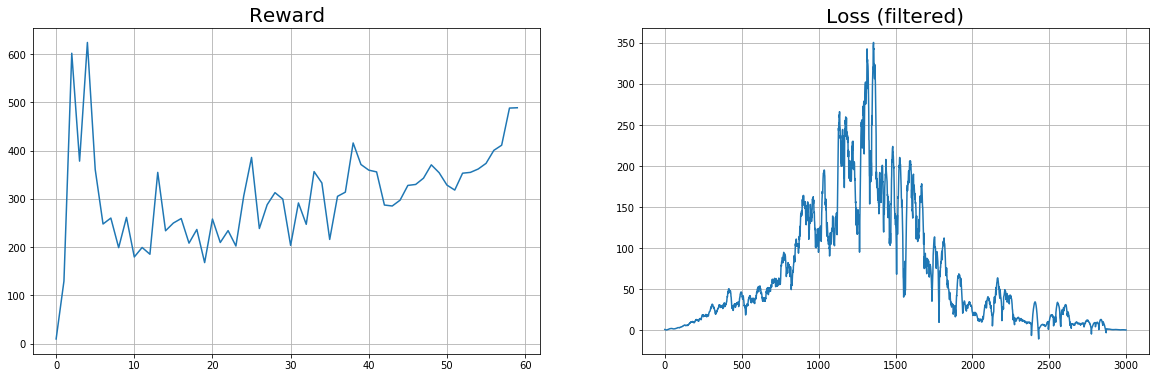

In [12]:
state = env.reset()

total_loss = []
total_reward = []

epsilon_discount_value = epsilon/epochs

for epoch in range(1, epochs+1):
    
    state, reward = play_n_steps(agent, state, 1)
    
    state_batch, action_batch, new_state_batch, reward_batch, done_batch = memory.pop(batch_size)
    loss = calculate_loss(state_batch, action_batch, new_state_batch, reward_batch, done_batch)
    
    loss.backward() # calculate the sum of gradients
    optimiser.step() # update model's parameters
    optimiser.zero_grad() # set gradients to zero
    
    # save loss for plot
    if epoch % 20 == 0:
        total_loss.append(loss.detach().cpu().item())
   
    # update epsilon
    agent.epsilon -= epsilon_discount_value
    
    # update target network with weights from 
    if epoch % update_target_rate == 0:
        target.qnetwork.load_state_dict(agent.qnetwork.state_dict())
        
    if epoch % 1000 == 0:
        total_reward.append(validation_test(n_episodes=3))
        
        clear_output(True)
        print("Progress {:.2f}% (Epoch {} from {}) \t epsilon {:.2f}".format(epoch*100/epochs, epoch, epochs, agent.epsilon))
        plt.figure(figsize=[20, 6])
        
        plt.subplot(1, 2, 1)
        plt.title("Reward", fontsize=20)
        plt.plot(total_reward)
        plt.grid()
        
        plt.subplot(1, 2, 2)
        plt.title("Loss (filtered)", fontsize=20) # Savitzky-Golay filter https://stackoverflow.com/a/20642478
        plt.plot(savgol_filter(total_loss, 49, 3))
        plt.grid()

        plt.show()

In [13]:
# test trained agent
reward = validation_test(n_episodes=100) 
print("Reward for 100 games:", reward)

Reward for 100 games: 473.0
